In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,9)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
torch.manual_seed(0)
import scipy.signal as sp
from torch.utils.data import TensorDataset

![simpleresnet.png](simpleresnet.png)

This exercies uses a simple implementation of a deep neural network to explore the vanishing gradient problem

We have provided an example of a very simple feed forward network that has a strongly vanishing gradient w.r.t. the weights that are increasingly close to the input end. 

Your job is to modify the network so that it uses skip connections and make observations on what happens to the gradient after. 

Text(0, 0.5, 'Weight Gradients')

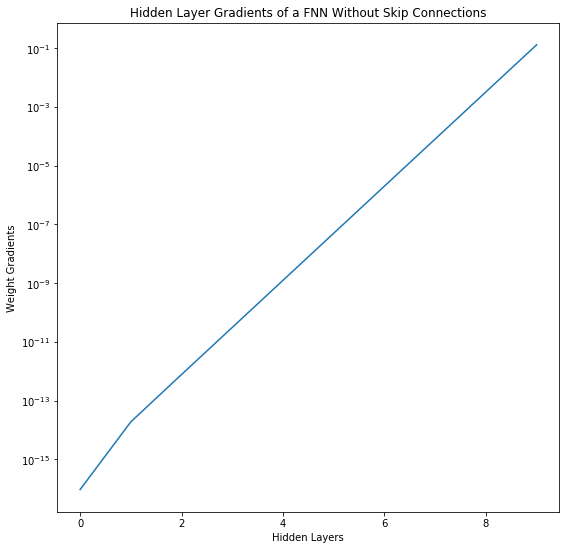

In [8]:
# Choose an activation function
activation = torch.sigmoid

# Choose a number of iterations
n = 50


# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.tensor([1.0])

# Initial value
# x = torch.randn((1,),requires_grad=True)
x = torch.tensor([0.1], requires_grad=True)
z_prev = x

# Loop over a number of hidden layers
for i in range(n):
    # New weight
    w_i = torch.tensor([0.1],requires_grad=True)

    # Linear transform
    a_i = z_prev*w_i

    # Activation
    zprime_i = activation(a_i)

    z_i = zprime_i
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
 

    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward()

# Print each weight's gradient
w_grad_init = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad_init.append(grad)
    
plt.semilogy(w_grad_init)
plt.title('Hidden Layer Gradients of a FNN Without Skip Connections')
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')

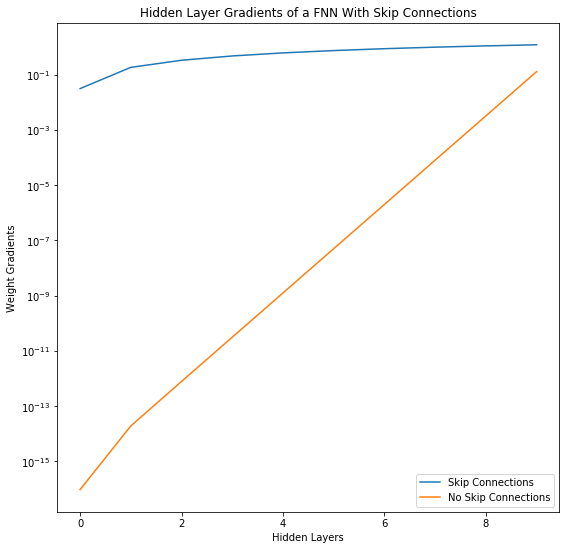

In [9]:
# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.randn((1,))
# Initial value
# x = torch.randn((1,),requires_grad=True)
x = torch.tensor([0.1], requires_grad=True)
z_prev = x
# Loop over a number of hidden layers



# skip1 = 2 #TODO
# skip2 = 3 #TODO  

    
for i in range(1,n+1):
    # New weight
    w_i = torch.tensor([0.1],requires_grad=True)
   
    # Linear transform
    a_i = w_i*z_prev 

    # Activation
    zprime_i = activation(a_i) 

    # TODO: replace the line below with one that would add a skip connection
#     if(i % skip1 == 0 and i >= skip1):
#         zprime_i.add(a_list[i-skip1])
        
#     if(i & skip2 == 0 and i >= skip2):
#         zprime_i.add(a_list[i-skip2])
    
    z_i = zprime_i.add(z_prev)
    
    # use the .add(tensor) method
    
    # think about how we would skip multiple layers using MULTIPLE skip lengths in this instance (hint, use branching and the modulus operator)
    
    # We found the results to be VERY non-linear
 
    
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
    a_list.append(a_i)
    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward()

# Print each weight's gradient
w_grad = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad.append(grad)

#w_grad = sp.savgol_filter(w_grad,5,3)
plt.semilogy(w_grad,label='Skip Connections')
plt.semilogy(w_grad_init,label='No Skip Connections') #compare to previous network
plt.title('Hidden Layer Gradients of a FNN With Skip Connections')
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')
plt.legend()


Now that we have seen how implementing skip connections seemingly solve the problem of vanishing gradients, we've learned all we can from the paper, lets look at some applications

------------

Below is a simple example of an image processing problem where vanishing gradient becomes an issue (no need to show it this time)

For training and testing data I generated random images for a training and test set. If the small problems are too easy feel free to increase the size of the datasets to make for more challenging problems

After you get done with the conceptual questions below, feel free to change the architecture of the below net. Make 3 changes to the architecture, record the loss difference after 100 iterations, and come up with a justification for that difference in loss

Now we will run an implemenation of a simple deep convolutional network on MNIST (handwritten numbers)

In [10]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_data = train_dataset.data[::20].unsqueeze(1).float()
train_targets = train_dataset.targets[::20].unsqueeze(1)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_data = test_dataset.data[::20].unsqueeze(1).float()
test_targets = test_dataset.targets[::20].unsqueeze(1)

training_data = TensorDataset(train_data,train_targets)
testing_data = TensorDataset(test_data,test_targets)

train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                          batch_size=100,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=100,
                                          shuffle=False)



This model allows you to input a specified number of convolutional layers in your network.

In [11]:
# basic net class
class Net(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            x = self.linears[i](zprev)
            zi = F.relu(x)
            zprev = zi
    
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


In [12]:
def train_model(epic, your_net):
        train_accuracy = []
        test_accuracy = []
        
        model = your_net
        model.to(device)

        criterion = torch.nn.CrossEntropyLoss() #since ive set this up as a classification problem with bins number of classes

        optimizer = torch.optim.Adam(model.parameters())

        epochs = epic
        # Loop over the data

        for epoch in range(epochs):
                model.train()
                # Loop over each subset of data

                correct = 0
                total = 0        

                for d,t in train_loader:
                        # Zero out the optimizer's gradient buffer
                        optimizer.zero_grad()
                        # Make a prediction based on the model
                        outputs = model(d)
                        # Compute the loss
                        loss = criterion(outputs,t[:,0])
                        # Use backpropagation to compute the derivative of the loss with respect to the parameters
                        loss.backward()
                        # Use the derivative information to update the parameters
                        optimizer.step()

                        
                        _, predicted = torch.max(outputs.data, 1)
                        correct += len(predicted[predicted==t[:,0]])
                        total += len(predicted.flatten())
                                
                correcttest = 0
                totaltest = 0        

                for d,t in test_loader:
                
                    outputs = model(d)
                    _, predicted = torch.max(outputs.data, 1)
                    correcttest += len(predicted[predicted==t[:,0]])
                    totaltest += len(predicted.flatten())
                
                if epoch%10==0:      
                        print(epoch,loss.item(), ' Train_Accuracy = ', correct/total*100,' Test_Accuracy = ', correcttest/totaltest*100)
                
                train_accuracy.append(correct/total*100)
                test_accuracy.append(correcttest/totaltest*100)
        
        return train_accuracy, test_accuracy

You can mess with these paramenters and see how your model performance changes

In [13]:
num_input_images = 100
num_classes = 10
device = torch.device("cpu")
num_epochs = 50 #how long to run the model
num_layers = 10 #how many convolutions to perform

In [ ]:
trainacc_init, testacc_init = train_model(num_epochs, Net(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainacc_init, label = 'training accuracy')
plt.plot(testacc_init, label = 'test accuracy')
plt.legend()
plt.show()

0 1.1281596422195435  Train_Accuracy =  34.166666666666664  Test_Accuracy =  66.4
10 0.1799296885728836  Train_Accuracy =  92.63333333333334  Test_Accuracy =  87.8
20 0.05556147173047066  Train_Accuracy =  97.36666666666667  Test_Accuracy =  88.8
30 0.09253314137458801  Train_Accuracy =  98.06666666666666  Test_Accuracy =  90.0


In a similar fashion to what you did on the previous FNN, add skip connects and see if you can improve the model.

In [11]:
# basic net class
''' NOTE:

        This example will not run on my computer. reguardless of number of layers, as it runs it continues to
        consume more and more memory until the OS is pushed off into swap space.
'''
# skip1 = # TODO fill in SKIPS
# skip2 = #


class ResNet(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        #self.linearization1 = nn.Linear(28,28)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
        self.a_list = []
        self.z_list = []
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            #ai = self.linearization(zprev)
          
            ai = self.linears[i](zprev)
            
            # TODO: Implement skip connections in a similar fashion to what was done previously.
            # Think carefully about your skip intervals, and what should be used where
            # hint: use the lists defined as a class object, the modulus operator, and the .add() method

            zi = F.relu(ai).add(zprev)
            
            
            zprev = zi
            self.z_list.append(zi)
            self.a_list.append(ai)
            
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


In [ ]:
trainacc, testacc = train_model(num_epochs, ResNet(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainacc, label = 'training accuracy (skip connects)')
plt.plot(testacc, label = 'test accuracy (skip connects)')
plt.plot(trainacc_init, label = 'training accuracy (no skip connects)')
plt.plot(testacc_init, label = 'test accuracy (no skip connects)')
plt.legend()
plt.show()

NOTE: The above code box would not run. No matter the number of layers, when this box is executed,
memory slowly climbs until it pushes my OS into swap space, effectively locking my computer.

**Questions**

1. What is the vanishing gradient problem, and what is its primary cause?


The vanishing gradient problem is caused by gradients getting small enough that numerical prescision begins to affect the numerical stability of the computation. It is an issue in deep networks.

It's primary cause is the chain rule; by chaining multiplications of very small gradients through the layers of the network, the gradients in deeper layers can be driven low enough to lose numerical prescision.

2. What are 4 limitations to optimizing a deep convolutional neural network?

Vanishing Gradients, exploding gradients, overfitting, and memory consumption.

3. In terms of how a given block of a network is "fitted", what is the key difference between using skip connections and traditional blocks?

Skip connections add in the result from a previous layer. This allows the block to simply pass the result from a previous layer to the next layer, if it is helful. By doing so, the block can more easily learn to  implement a network with fewer layers if that is actually a better network for the task.


4. In the context of model hyper-parameters, what additional parameters is added in the res-net implementation?

The number of layers to skip for each skip connection can be added as hyperparameters. In the above example, I implemented a skip connection that simply allows for skipping each layer, so these hyperparameters are not required in this case.

5. How do skip connections resolve the "vanishing gradient" problem? (Open Ended)

The paper does not explicitly state that this solves the vanishing gradient problem. The paper states that previous literature has suggested that skip connections can address the vanishing gradient problem, but gives no reasoning behind it. 

This paper implicitly suggests that the vanishing gradient problem is resolved by the addition of the previous input. By trying to learn H(x) =  F(x) + x, the added x includes an addition into the chain of derivatives, allowing the deeper gradients to not be continually driven small enough to destroy numerical prescision.


6. Give an appropriate anology for how kernels are used to extract features from images (i.e. sanding wood)

Kernels are like punch cards. You apply one to some data, and look through the holes. By selectively focusing on specific elements in the data (what shows through the holes in the card), each different kernel (punch card) highlights a specific features to focus on. 

7. Was this a good paper when it was released? Is it a good paper now? What has changed between now and it's initial release point? What other methods are there of solving the vanishing gradient problem? (Open Ended)

This paper does not include all the context and analysis that I would hope for, but I think the correct context for this paper is more of a "novel technique that works but we don't exactly know why", than a holistic methodology. I thik that it's a bit of a curio by its self, but when combined with the numerous publications that build on it and explore the idea of residules/ skip connections, it's valid research and useful literature. 

After some quick googling, LSTMs seem to address the vanishing gradient problem as well. As we discussed in class, some prominent researchers seem to think that ResNet is just an application of LSTMs anyway.

Networks that use ReLUs seem to help with the vanishing gradient since they can only saturate positively, but it would seem to me that they wouldn't solve the issue of tiny -positive- gradients.

Batch Normalization has been suggested to address this problem as well, since normalizing the input to the sigmoid makes it less likely to be on the outer edges of the sigmoid (where the gradient is tiny).

8. What interval of skip connections did you use and where were they applied to? Did you find any #accuracygainz ?

For my example, I followed doug's lead and added a skip connection of length 1 between every layer. I did see excellent accuracy gains on the first example. As mentioned above, the second example would not run due to the explosive memory cost.